# CARFF Mixture Density Network

In [32]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import json
import tqdm
from sklearn.manifold import TSNE
import os

In [33]:
latent_dim = 8
hidden_dim = 512
batch_size = 128
num_epochs = 500
lr = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
town = 3
K = 2

In [34]:
def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps * std + mu

In [35]:
path = "path/to/transforms_train.json"

f = open(path, "r")
data = json.load(f)

In [37]:
latents = {}
mus = {}
log_vars = {}
for frame in data["frames"]:
    # latents
    if frame["scene_id"] in latents.keys():
        latents[frame["scene_id"]].append(frame["latents"])
    else:
        latents[frame["scene_id"]] = [frame["latents"]]
    # mu
    if frame["scene_id"] in mus.keys():
        mus[frame["scene_id"]].append(frame["mu"])
    else:
        mus[frame["scene_id"]] = [frame["mu"]]
    # var
    if frame["scene_id"] in log_vars.keys():
        log_vars[frame["scene_id"]].append(frame["var"])
    else:
        log_vars[frame["scene_id"]] = [frame["var"]]

## Mixed Gaussian Predictions

In [40]:
class TensorDataset(Dataset):
    def __init__(self, all_mus, all_vars, all_latents):
        assert len(all_mus) == len(all_vars)
        self.all_mus = self.lists_to_tensors(all_mus)
        self.all_vars = self.lists_to_tensors(all_vars)
        self.all_latents = self.lists_to_tensors(all_latents)
        self.num_scenes = len(all_mus)
        self.num_scenes_temp = self.num_scenes + 1
    
    def lists_to_tensors(self, dictionary):
        for key, value in dictionary.items():
            dictionary[key] = torch.tensor(value).to(device)
        return dictionary

    def __len__(self):
        return len(self.all_mus[0])

    def __getitem__(self, idx):
        factor = torch.randint(0,2, (1,)).item()
        scene = torch.randint(0, self.num_scenes_temp // 2 - 1, (1,)).item()

        start_scene = factor*(self.num_scenes_temp // 2) + (scene)  
        one_hot_encode = F.one_hot(torch.tensor([scene]), self.num_scenes_temp -1).to(device)

        end_scene = start_scene + 1

    
        start_mu = self.all_mus[start_scene][idx]
        start_latents = self.all_latents[start_scene][idx]
        start_var = self.all_vars[start_scene][idx]
        
        idx = idx + torch.randint(-4, 4, (1,))[0]
        if idx >= self.num_scenes:
            idx = self.num_scenes - 1
        end_mu = self.all_mus[end_scene][idx]
        end_var = self.all_vars[end_scene][idx] # TODO one hot encode scene id to condition MLP
        end_latents = self.all_latents[end_scene][idx] # TODO one hot encode scene id to condition MLP

        gaussian_noise1 = torch.randn(start_mu.shape).cuda() * 0.005
        gaussian_noise2 = torch.randn(start_var.shape).cuda() * 0.005

        return torch.cat([start_mu + gaussian_noise1, start_var + gaussian_noise2]), torch.cat([end_mu, end_var])

In [41]:


class MDN(nn.Module):
   
    def __init__(self, dim_in, dim_out, n_components, hidden_dim,):
        super().__init__()
        num_sigma_channels =  dim_out * n_components
        self.dim_in, self.dim_out, self.n_components = dim_in, dim_out, n_components
        
        self.base = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.mu_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim_out * n_components)
            )
        
        self.sigma_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_sigma_channels)
            )

        self.pi_head = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_components),
        )
    def forward(self, x, eps=1e-6):
        shared_output = F.relu(self.base(x))
        pis = self.pi_head(x)
        log_pi = torch.log_softmax(pis, dim=-1)
        mu = self.mu_head(shared_output)
        sigma = self.sigma_head(shared_output)

        sigma = torch.exp(sigma + eps)
        mu = mu.reshape(-1, self.n_components, self.dim_out)
        sigma = sigma.reshape(-1, self.n_components, self.dim_out)
        return log_pi, mu, sigma

    def loss_mod(self, mu, sigma, log_pi, y):
        z_score = (y - mu) / sigma
        
        if len(y.shape) == 3:
            normal_loglik = (
                -0.5 * torch.einsum("bij,bij->bi", z_score, z_score)
                -torch.sum(torch.log(sigma), dim=-1)
            )
        else:
            normal_loglik = (
                -0.5 * torch.einsum("bijc,bijc->bij", z_score, z_score)
                - torch.sum(torch.log(sigma), dim=-1)
            )


        loglik = torch.logsumexp(log_pi + normal_loglik, dim=-1)
        return -loglik.sum()

    
    def sample(self, x):
        log_pi, mu, sigma = self.forward(x)
        weights = torch.exp(log_pi)
        cum_pi = torch.cumsum(weights, dim=-1)
        rvs = torch.rand(len(x), 1).to(x)
        rand_pi = torch.searchsorted(cum_pi, rvs)
        rand_normal = torch.randn_like(mu) * sigma + mu
        samples = torch.take_along_dim(rand_normal, indices=rand_pi.unsqueeze(-1), dim=1).squeeze(dim=1)
        return samples, weights, mu, sigma

    def save(self, path):

        checkpoint = {
            "model_state_dict": self.state_dict(),
        }
        
        torch.save(checkpoint, os.path.join(path, "checkpoint.pth"))

    def load(self, path):

        checkpoint = torch.load(os.path.join(path, "checkpoint.pth"))
        self.load_state_dict(checkpoint["model_state_dict"])
                
        return checkpoint

In [42]:
import torch.optim.lr_scheduler as lr_scheduler
num_epochs = 30000
lr = 0.005


In [43]:
from torch.quasirandom import SobolEngine

num_samples = 1000
sobol_engine = SobolEngine(dimension=latent_dim, scramble=True)

In [44]:
model = MDN(2*latent_dim,latent_dim, K, hidden_dim).to(device)

dataset = TensorDataset(mus, log_vars, latents)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

progress_bar = tqdm.tqdm(range(num_epochs), desc="Loss: ---", position=0)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=10000)

losses = []

for epoch in progress_bar:
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        weights, mu_preds, var_preds = model(batch_X)

        samples_sobol = sobol_engine.draw(num_samples).to(torch.float).to(device)
        samples_sobol = samples_sobol[None,:,None,:].repeat(batch_y.shape[0], 1, K,1)
        
        batch_y = batch_y[:,None,None,:].repeat(1,num_samples,K,1)
        latent_vectors = samples_sobol * torch.exp(batch_y[...,latent_dim:]) + batch_y[...,:latent_dim]
        loss = model.loss_mod(mu_preds[:,None,...].repeat(1,num_samples,1,1),var_preds[:,None,...].repeat(1,num_samples,1,1),weights[:,None].repeat(1,num_samples,1),latent_vectors)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
    losses.append(loss.item())
    progress_bar.set_description(f"Loss: {loss.item():.4f}")

Loss: -440438.5312: 100%|█████████████████| 30000/30000 [28:24<00:00, 17.60it/s]


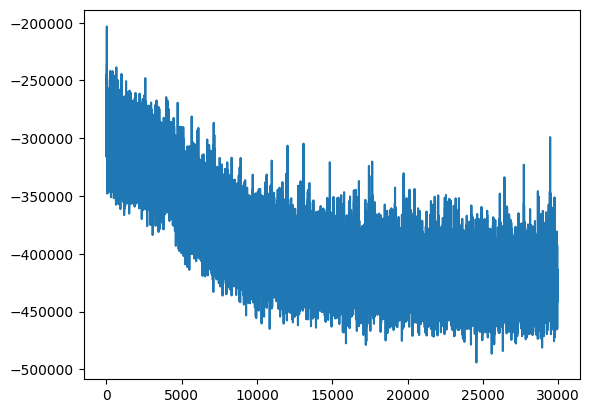

In [45]:
plt.plot(range(len(losses[50:])), losses[50:])

In [46]:
model.save(os.path.dirname(path))